# Steps
* Objective
* Data Wrangling
* Model Generation
* Submission

# Objective

Objective is to build a model to find the different data groups/clusters. 
The data given are (simulated) manufacturing control data that can be clustered into different control states. There is no indication of how many possible control states there are. Its an Unsupervised Learning problem

# Data Wrangling

In [1]:
# Importing necessary libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MaxAbsScaler,PowerTransformer,RobustScaler,StandardScaler, MinMaxScaler

from collections import Counter
from tqdm import tqdm
print("Necessary Libraries imported")

Necessary Libraries imported


In [2]:
# Getting the file names
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [3]:
# importing data
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv",index_col="id")
submission = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv")
print("Data Imported")

Data Imported


In [4]:
# Data top 5 rows
data.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [5]:
# Data shape
data.shape

(98000, 29)

In [6]:
# Basic data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

In [7]:
# Basic stats
data.describe().T

,count,mean,std,min,25%,50%,75%,max
f_00,98000.0,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.0,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.0,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.0,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.0,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.0,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.0,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.0,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.0,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.0,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


* Seems no missing values here
* Maximum value of 44 in feature f_09
* Minimum value of -8.234305 in feature f_23
* Need to tranform the data with scaler

In [8]:
# Column list of data
cols = list(data.columns)

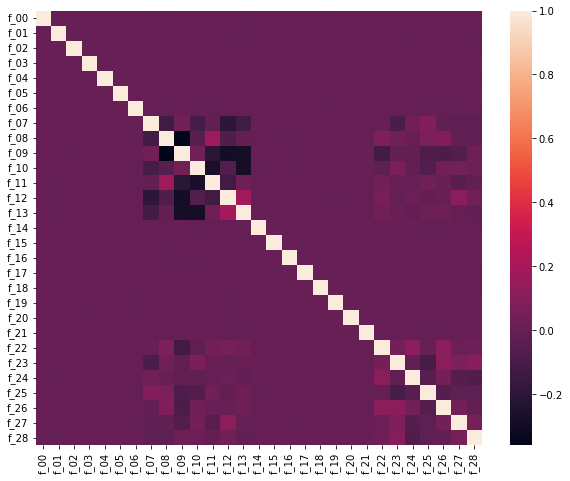

In [9]:
# Checking for correlations
plt.figure(figsize=(10,8))
sns.heatmap(data.corr())
plt.show()

Seems no strong relationship among the features, but some features are negatively correlated also

Using Scalers and Transformer for data transformation
* Scalers are linear (or more precisely affine) transformers and differ from each other in the way they estimate the parameters used to shift and scale each feature.
* PowerTransformer provides non-linear transformations in which data is mapped to a normal distribution to stabilize variance and minimize skewness.

In [10]:
# Standardisation of data
# Using MaxAbs scaler as Robust scaler used earlier

Abs_scaler = MaxAbsScaler().fit(data)
data_standard = Abs_scaler.fit_transform(data)

# Transforming data with Power Transformer
power_transformer = PowerTransformer().fit(data_standard)
data_transformed = power_transformer.transform(data_standard)
data_transformed = pd.DataFrame(data_transformed,columns = cols)

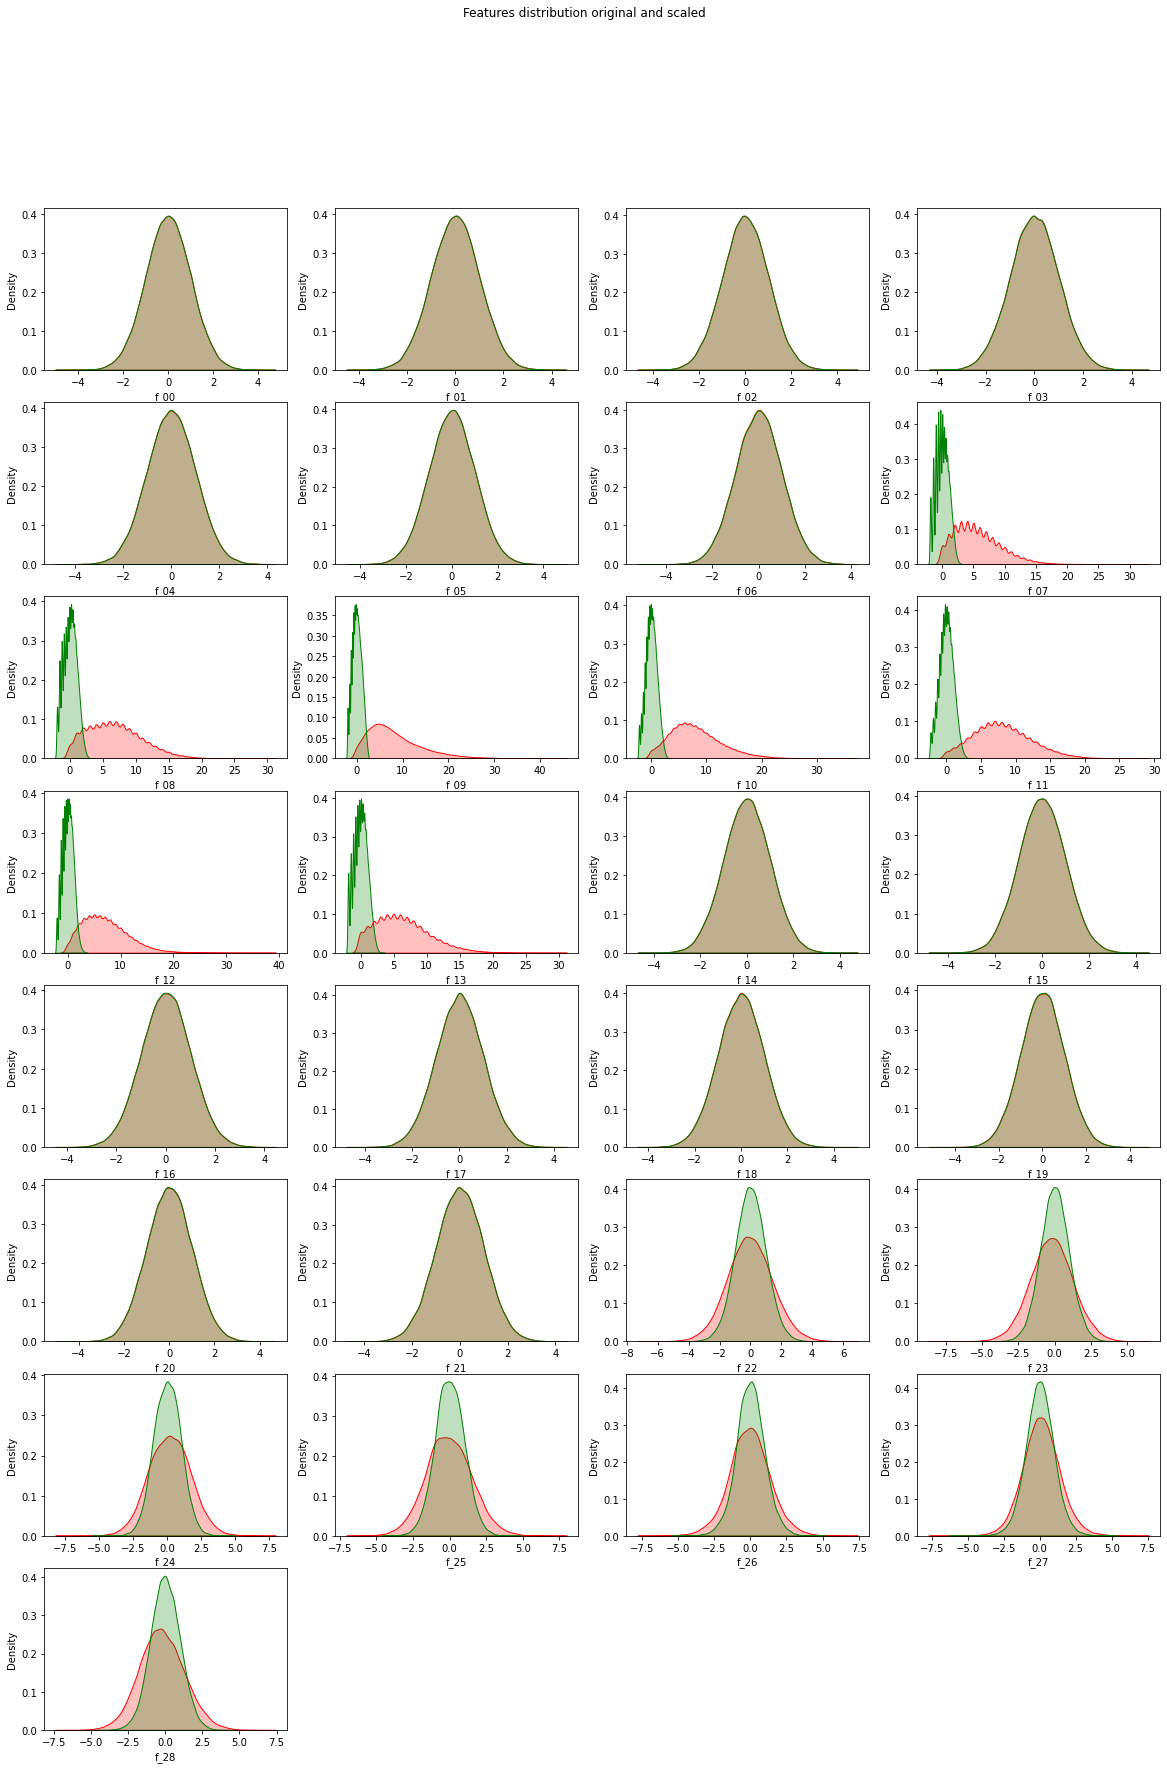

In [11]:
# Plotting distributions of individual features

plt.figure(figsize=(20,28))
for index,col in enumerate(cols):
    plt.subplot(8,4,index+1)
    sns.kdeplot(x = data[col],shade="fill",color="red")
    sns.kdeplot(x = data_transformed[col],shade="fill",color="green")   
plt.suptitle("Features distribution original and scaled")
plt.show()

The features with integer valuers are originally skewed, transformed to be Gaussian like.

In [12]:
# Robust scaler for comparison of scaling

Robust_scaler = RobustScaler().fit(data)
data_standard_r = Robust_scaler.fit_transform(data)

# Transforming data with Power Transformer
power_transformer_r = PowerTransformer().fit(data_standard_r)
data_transformed_r = power_transformer_r.transform(data_standard_r)
data_transformed_r = pd.DataFrame(data_transformed_r,columns = cols)

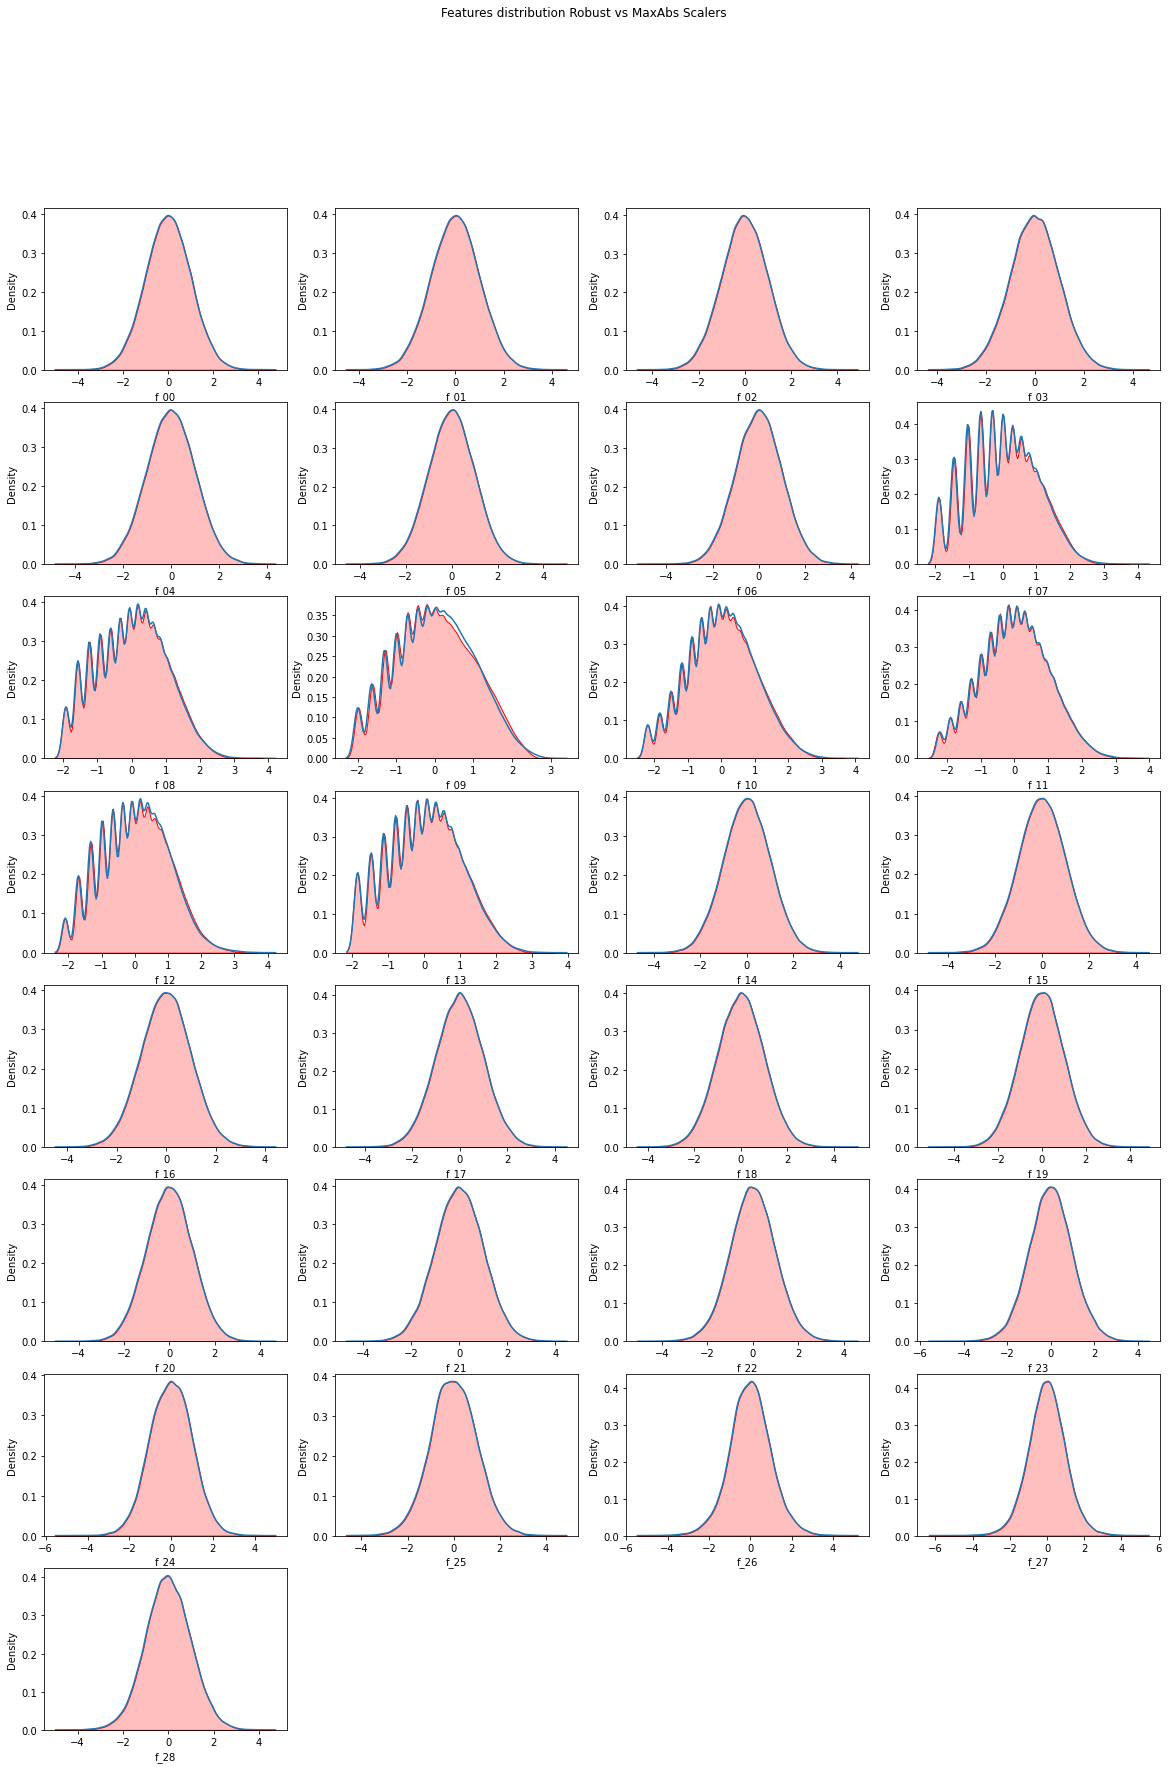

In [13]:
# Plotting distributions of features with Robust scaler and MaxAbs scaler

plt.figure(figsize=(20,28))
for index,col in enumerate(cols):
    plt.subplot(8,4,index+1)
    sns.kdeplot(x = data_transformed[col],shade="fill",color="red")   
    sns.kdeplot(x = data_transformed_r[col]) 
plt.suptitle("Features distribution Robust vs MaxAbs Scalers")
plt.show()

Seems there is no much difference in the distibution of data after scaling with Robust scaler and MaxAbs scaler with power transformations. I am checking with MaxAbs scaler as earlier tried Robust scaler, expecting a different result

# Model Generation

Tried KMeans & gaussian earlier, the results of KMeans were not impressive, but the results of Gaussian were promising, so focusing on Gaussian & Bayesian mixture models for clustering. Checking on AIC & BIC scores for Gaussian Models.

The Akaike information criterion (AIC) & Bayesian Information Criterion (BIC) gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower the values, the better is the model to actually predict the data we have.

Not used Silhouette scores here, as in the earlier kernels, not able to decide the size of the clusters based on Silhouette score as the scores were near to zero.

In [14]:
# Gaussian Mixture model over range of n clusters
gmm_aic = []
gmm_bic = []
for k in tqdm(range(5, 20)):
    gmm = GaussianMixture(n_components=k,random_state=1,n_init=2).fit(data_transformed)
    labels_gmm = gmm.predict(data_transformed)
    
    # Appending BIC values to the list
    gmm_bic.append(gmm.bic(data_transformed))
    gmm_aic.append(gmm.aic(data_transformed))

#Gradient of BIC values
gmm_bic_gradient = np.gradient(gmm_bic)

100%|██████████| 15/15 [24:08<00:00, 96.58s/it] 


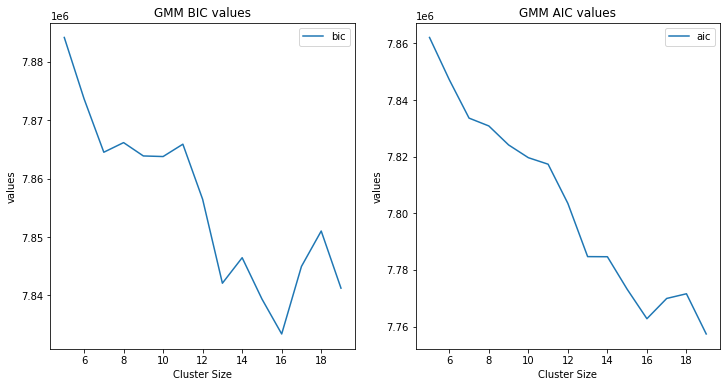

In [15]:
# Plotting the model scores

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(range(5,20),gmm_bic,label='bic')
plt.xlabel("Cluster Size")
plt.ylabel("values")
plt.legend()
plt.title("GMM BIC values")

plt.subplot(122)
plt.plot(range(5,20),gmm_aic,label='aic')
plt.xlabel("Cluster Size")
plt.ylabel("values")
plt.legend()
plt.title("GMM AIC values")

plt.show()

From the chart, after 7 clusters, the bic value is smooth, Seems 7/8 may be the optimal clusters. Going with 7 as earlier also 7 clusters gave good score

In [16]:
# Model with Gaussian mixture
model = GaussianMixture(n_components=7,random_state=1,n_init=10,covariance_type='full').fit(data_transformed)
labels = model.predict(data_transformed)
Counter(labels)

Counter({2: 13623, 1: 12662, 4: 12313, 0: 16178, 3: 15446, 6: 15857, 5: 11921})

In [17]:
# Model with Bayesian Gaussian mixture model
model_b = BayesianGaussianMixture(n_components=7,random_state=1,n_init=10,covariance_type='full').fit(data_transformed)
labels_b = model_b.predict(data_transformed)
Counter(labels_b)

Counter({4: 13825, 6: 10730, 2: 12816, 1: 17239, 5: 16062, 3: 16124, 0: 11204})

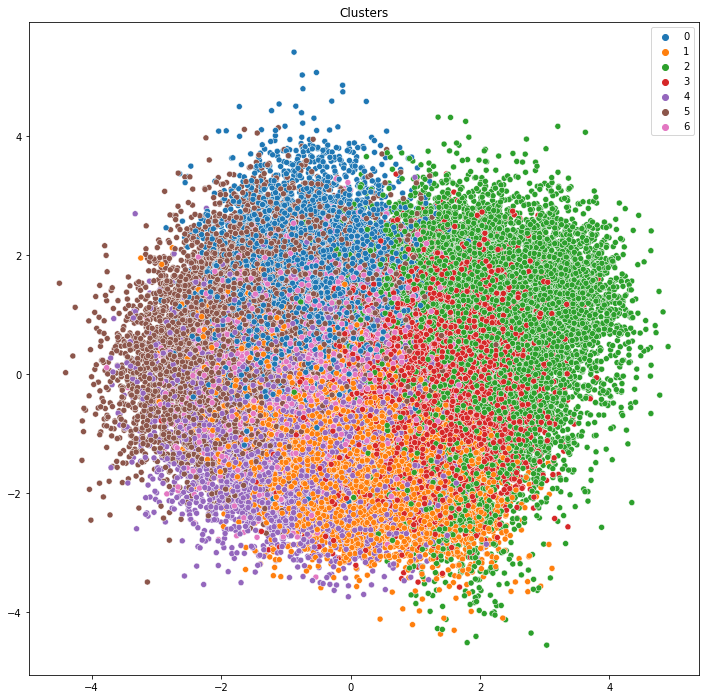

In [18]:
# Visualizing the clusters with PCA of Bayesian Gaussian Mixture model with normalized data
pca = PCA(2).fit_transform(data_transformed)

plt.figure(figsize=(12,12))
sns.scatterplot(x=pca[:,0],y=pca[:,1],hue=labels_b,palette='tab10')
plt.title("Clusters")
plt.show()

# Submission

In [19]:
# Submission file
# Considering the Bayesian Gaussian mixture model labels
submission["Predicted"] = labels_b
submission.to_csv("submission.csv", index=False)